In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import json 
from pandas.io.json import json_normalize


#Charger données type de commune (aire urbaine....)
df = pd.read_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/COMARR_conso.csv",sep = ';')
#Charger base code insee/code postal 
df2 = pd.read_csv('/Users/veillonpaul-armand/Documents/Projets/Data/Carto/correspondance-code-insee-code-postal.csv',sep=";")
df2=df2.drop(["Code Canton","Code Arrondissement","ID Geofla","Commune","Département","Région"],axis=1)





In [54]:
### Ajouter des variable au level commune


#Base IRIS complete populatin
df_iris = pd.read_excel("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/base-ic-evol-struct-pop-2015.xls", sheet_name='IRIS')
df_iris=df_iris.drop(df.index[[0,1,2,3]])
df_iris.columns = list(df_iris.iloc[0,:])
df_iris=df_iris.drop(df_iris.index[[0]])
df_iris.head(5)

# At the com level

#Create a data.frame at the com level
df_com=df_iris.groupby(['COM'])['P15_POP'].sum()
df_com=df_com.to_frame()
df_com.head(5)

#Calcul variable add the COM level:
var=["P15_POP65P","C15_POP15P","C15_POP15P_CS1","C15_POP15P_CS2",
     "C15_POP15P_CS3","C15_POP15P_CS4","C15_POP15P_CS5","C15_POP15P_CS6",
     "C15_POP15P_CS7","C15_POP15P_CS8","P15_POP_FR","P15_POP_ETR","P15_POP_IMM"]
for i in var:
    df_com_bis=df_iris.groupby(['COM'])[i].sum()
    df_com_bis=df_com_bis.to_frame()
    df_com=df_com.merge(df_com_bis,how="left",on="COM")
 
#Mettre le code insee au bon format (supprimer le zero si pas cors)
df_com.head(5)
df_com["COM"]=df_com.index
df_com.loc[df_com["COM"].str[0]=="0","COM"]=df_com.loc[df_com["COM"].str[0]=="0","COM"].str[1:]


#Ajouter la variable niveau de vie
df_rev = pd.read_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/niveaudevie_COM.csv",sep=";",decimal=',')
df_rev=df_rev.iloc[:,0:2]
df_com=df_com.merge(df_rev,how="left",on="COM")

print(df_com.columns)

#Merge with the code postal code insee database
df2=df2.merge(df_com,how="left",left_on="Code INSEE", right_on="COM")

del df_iris, df_com_bis,df_com, df_rev


Index(['P15_POP', 'P15_POP65P', 'C15_POP15P', 'C15_POP15P_CS1',
       'C15_POP15P_CS2', 'C15_POP15P_CS3', 'C15_POP15P_CS4', 'C15_POP15P_CS5',
       'C15_POP15P_CS6', 'C15_POP15P_CS7', 'C15_POP15P_CS8', 'P15_POP_FR',
       'P15_POP_ETR', 'P15_POP_IMM', 'COM', 'MED14'],
      dtype='object')


/Users/veillonpaul-armand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: 'COM' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [55]:
#Merge on df
df=df.merge(df2,how="left",left_on="CODGEO", right_on="Code INSEE")

#Pour les codes postales avec plusieur communes, assignés au CP la population moyenne pondérée des villages
df['Counts'] = df.groupby(['Code Postal'])['CODGEO'].transform('count')
df['POP_CP'] = df.groupby(['Code Postal'])['P15_POP'].transform('sum')

#Calculer la moyenne de la taille des communes pour chaque CP
df['POP_mean_CP']=df['P15_POP'] **2/df['POP_CP']
df['POP_mean_CP']=df.groupby(['Code Postal'])['POP_mean_CP'].transform('sum')

#Calculer la moyenne pondérée pour toutes ces variables
var=['P15_POP',"P15_POP65P","C15_POP15P","C15_POP15P_CS1","C15_POP15P_CS2",
     "C15_POP15P_CS3","C15_POP15P_CS4","C15_POP15P_CS5","C15_POP15P_CS6",
     "C15_POP15P_CS7","C15_POP15P_CS8","P15_POP_FR","P15_POP_ETR","P15_POP_IMM"]
var_mean=list()
for i in var:
    df[i+"mean_CP"]=df[i]/df['POP_CP'] 
    df[i+'mean_CP']=df.groupby(['Code Postal'])[i+'mean_CP'].transform('sum')
    var_mean.append(i+'mean_CP') 

#Calculer moyenne pondérée revenu en tenant compte des NAN
df["rev_CP"]=df.groupby(['Code Postal'])["MED14"].transform('mean')

#REPLace null value par the value of the CP
df.loc[df["MED14"].isnull(),"MED14"]=df.loc[df["MED14"].isnull(),"rev_CP"]
df["rev_CP"]=df['P15_POP']*df["MED14"]/df['POP_CP']
df["rev_CP"]=df.groupby(['Code Postal'])["rev_CP"].transform('sum')




In [56]:
#Assigné la taille d'unité urbaine pour chaque code postal (si différent pour un même code postal, assigné le max)
df['CP_TUU']=df.groupby(['Code Postal'])['TUU2015'].transform("max")
df=df[["Code Région","Code Département","Code Postal","Code INSEE","Counts","POP_CP","POP_mean_CP","CP_TUU","LIBGEO","rev_CP"]+var_mean]
df=df.drop_duplicates(["Code Région","Code Département","Code Postal"])
df=df[~df.isnull().any(axis=1)]





In [57]:
#Si commune avec plusieurs code postaux, dupliquer la ligne avec le même code postal

vec=df.loc[df["Code Postal"].str.find("/")!=(-1),"Code Postal"]

for i in vec:
    cp=i.split("/")
    df_bis=df[df["Code Postal"]==i] 
   
    for j in cp:
        df_bis["Code Postal"]=j
        df=pd.concat([df,df_bis])

df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df=df[~df["Code Postal"].isin(vec)]
df["Code Postal"]=pd.to_numeric(df["Code Postal"])

#Assigner le quantile de revenu du code postal
vec=np.linspace(0.1,0.9,9)
df["quantile_rev"]=0
df.loc[df["rev_CP"].isnull(),"quantile_rev"]=np.nan
for i in vec:
    df.loc[df["rev_CP"]>df["rev_CP"].quantile(i),"quantile_rev"]=i
    
#Assigner le quantile de CSP Ouvrier du code postal
vec=np.linspace(0.1,0.9,9)
df["quantile_ouv"]=0
df.loc[df[ "C15_POP15P_CS6mean_CP"].isnull(),"quantile_ouv"]=np.nan
for i in vec:
    df.loc[df["C15_POP15P_CS6mean_CP"]>df["C15_POP15P_CS6mean_CP"].quantile(i),"quantile_ouv"]=i    

#Assigner le quantile de CSP+ du code postal
vec=np.linspace(0.1,0.9,9)
df["quantile_CSP+"]=0
df.loc[df[ "C15_POP15P_CS3mean_CP"].isnull(),"quantile_CSP+"]=np.nan
for i in vec:
    df.loc[df["C15_POP15P_CS3mean_CP"]>df["C15_POP15P_CS3mean_CP"].quantile(i),"quantile_CSP+"]=i      

#Assigner le quantile de Retraité du code postal
vec=np.linspace(0.1,0.9,9)
df["quantile_retired"]=0
df.loc[df[ "C15_POP15P_CS7mean_CP"].isnull(),"quantile_retired"]=np.nan
for i in vec:
    df.loc[df["C15_POP15P_CS7mean_CP"]>df["C15_POP15P_CS7mean_CP"].quantile(i),"quantile_retired"]=i  

#Assigner le quantile employé  du code postal
vec=np.linspace(0.1,0.9,9)
df["quantile_emp"]=0
df.loc[df[ "C15_POP15P_CS5mean_CP"].isnull(),"quantile_emp"]=np.nan
for i in vec:
    df.loc[df["C15_POP15P_CS5mean_CP"]>df["C15_POP15P_CS5mean_CP"].quantile(i),"quantile_emp"]=i       

/Users/veillonpaul-armand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [58]:

df.to_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/CP_conso.csv")

In [7]:
#Merge with data grand débat
with open("/Users/veillonpaul-armand/Documents/Projets/Data/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN=json_normalize(json_data)
df_GN=df_GN.drop(df_GN.columns[0],axis=1)
df_GN['Thème']="Fiscalité"


with open("/Users/veillonpaul-armand/Documents/Projets/Data/LA_TRANSITION_ECOLOGIQUE_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1=df_GN1.drop(list(df_GN1.columns[:6]),axis=1)
df_GN1['Thème']="Transition Ecologique"
df_GN=pd.concat([df_GN,df_GN1])

with open("/Users/veillonpaul-armand/Documents/Projets/Data/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1=df_GN1.drop(list(df_GN1.columns[:8]),axis=1)
df_GN1['Thème']="Organisation de l'Etat"
df_GN=pd.concat([df_GN,df_GN1])

with open("/Users/veillonpaul-armand/Documents/Projets/Data/DEMOCRATIE_ET_CITOYENNETE_short.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)
df_GN1=json_normalize(json_data)
df_GN1=df_GN1.drop(list(df_GN1.columns[:6]),axis=1)
df_GN1['Thème']="Démocratie et Citoyenneté"
df_GN=pd.concat([df_GN,df_GN1])

#del df_GN1
del json_data

df_GN.groupby(['Thème'])['reference'].count()

Thème
Démocratie et Citoyenneté    49026
Fiscalité                    85931
Organisation de l'Etat       51618
Transition Ecologique        64669
Name: reference, dtype: int64

In [8]:

#Cleaning CP, le CP est renseigné par l'utilisateur, ne garder que les valeurs plausibles
df_GN["authorZipCode"]=pd.to_numeric(df_GN["authorZipCode"])
df_GN.loc[df_GN["authorZipCode"]<1000,"authorZipCode"]=np.nan
df_GN.loc[df_GN["authorZipCode"]>98999,"authorZipCode"]=np.nan
df_GN["DEP"]=df_GN["authorZipCode"]/1000
df_GN["DEP"]=df_GN["DEP"].fillna(0).astype('int')






In [10]:
#Create table at dep level and cp_level
pop = pd.read_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/pop_dep.csv",sep = ';')

#All contributions
all_ref=df_GN.groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_all","Total":"Population"},inplace=True)
pop["Count_all"]=pd.to_numeric(pop["Count_all"])
pop["Count_pourmil"]=pop["Count_all"]/pop["Population"]*1000

all_ref=df_GN.groupby(["authorZipCode"])['reference'].count()
all_ref=all_ref.to_frame()
df=df.merge(all_ref,how="left", right_on="authorZipCode",left_on="Code Postal")
df.rename( columns={"reference": "Count_all_CP",},inplace=True)
df["Count_all_CP"]=pd.to_numeric(df["Count_all_CP"])
df["Count_pourmil_CP"]=df["Count_all_CP"]/df["POP_CP"]*1000

#Trimming outliers
df.loc[df["Count_pourmil_CP"]>20,"Count_pourmil_CP"]=20


#Fisca
all_ref=df_GN[df_GN["Thème"]=="Fiscalité"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_fisca"},inplace=True)
pop["Count_fisca"]=pd.to_numeric(pop["Count_fisca"])
pop["perc_fisca"]=pop["Count_fisca"]/pop["Count_all"]

all_ref=df_GN[df_GN["Thème"]=="Fiscalité"].groupby(["authorZipCode"])['reference'].count()
all_ref=all_ref.to_frame()
df=df.merge(all_ref,how="left",right_on="authorZipCode",left_on="Code Postal")
df.rename( columns={"reference": "Count_fisca_CP",},inplace=True)
df["Count_fisca_CP"]=pd.to_numeric(df["Count_fisca_CP"])
df["Count_fiscapourmil_CP"]=df["Count_fisca_CP"]/df["POP_CP"]*1000
df["perc_fisca"]=df["Count_fisca_CP"]/df["Count_all_CP"]
#Trimming outliers
df.loc[df["Count_fiscapourmil_CP"]>10,"Count_fiscapourmil_CP"]=10

#Ecologie
all_ref=df_GN[df_GN["Thème"]=="Transition Ecologique"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_ecolo"},inplace=True)
pop["Count_ecolo"]=pd.to_numeric(pop["Count_ecolo"])
pop["perc_ecolo"]=pop["Count_ecolo"]/pop["Count_all"]

all_ref=df_GN[df_GN["Thème"]=="Transition Ecologique"].groupby(["authorZipCode"])['reference'].count()
all_ref=all_ref.to_frame()
df=df.merge(all_ref,how="left",right_on="authorZipCode",left_on="Code Postal")
df.rename( columns={"reference": "Count_ecolo_CP",},inplace=True)
df["Count_ecolo_CP"]=pd.to_numeric(df["Count_ecolo_CP"])
df["Count_ecolopourmil_CP"]=df["Count_ecolo_CP"]/df["POP_CP"]*1000
df["perc_ecolo"]=df["Count_ecolo_CP"]/df["Count_all_CP"]
#Trimming outliers
df.loc[df["Count_ecolopourmil_CP"]>10,"Count_ecolopourmil_CP"]=10

#Citoyenneté
all_ref=df_GN[df_GN["Thème"]=="Démocratie et Citoyenneté"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_cit"},inplace=True)
pop["Count_cit"]=pd.to_numeric(pop["Count_cit"])
pop["perc_cit"]=pop["Count_cit"]/pop["Count_all"]

all_ref=df_GN[df_GN["Thème"]=="Démocratie et Citoyenneté"].groupby(["authorZipCode"])['reference'].count()
all_ref=all_ref.to_frame()
df=df.merge(all_ref,how="left",right_on="authorZipCode",left_on="Code Postal")
df.rename( columns={"reference": "Count_cit_CP",},inplace=True)
df["Count_cit_CP"]=pd.to_numeric(df["Count_cit_CP"])
df["Count_citpourmil_CP"]=df["Count_cit_CP"]/df["POP_CP"]*1000
df["perc_cit"]=df["Count_cit_CP"]/df["Count_all_CP"]
#Trimming outliers
df.loc[df["Count_citpourmil_CP"]>10,"Count_citpourmil_CP"]=10

#Etat
all_ref=df_GN[df_GN["Thème"]=="Organisation de l'Etat"].groupby(['DEP'])['reference'].count()
all_ref=all_ref.to_frame()
pop=pop.merge(all_ref,how="left",on="DEP")
pop.rename( columns={"reference": "Count_etat"},inplace=True)
pop["Count_etat"]=pd.to_numeric(pop["Count_etat"])
pop["perc_etat"]=pop["Count_etat"]/pop["Count_all"]


all_ref=df_GN[df_GN["Thème"]=="Organisation de l'Etat"].groupby(["authorZipCode"])['reference'].count()
all_ref=all_ref.to_frame()
df=df.merge(all_ref,how="left",right_on="authorZipCode",left_on="Code Postal")
df.rename( columns={"reference": "Count_etat_CP",},inplace=True)
df["Count_etat_CP"]=pd.to_numeric(df["Count_etat_CP"])
df["Count_etatpourmil_CP"]=df["Count_etat_CP"]/df["POP_CP"]*1000
df["perc_etat"]=df["Count_etat_CP"]/df["Count_all_CP"]
#Trimming outliers
df.loc[df["Count_etatpourmil_CP"]>10,"Count_etatpourmil_CP"]=10

pop.to_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/GN_conso_dep_level.csv")
df.to_csv("/Users/veillonpaul-armand/Documents/Projets/Data/Carto/GN_conso_CP_level.csv")

In [11]:
df.head(5)


,Code Région,Code Département,Code Postal,Code INSEE,Counts,POP_CP,POP_mean_CP,CP_TUU,LIBGEO,rev_CP,...,perc_fisca,Count_ecolo_CP,Count_ecolopourmil_CP,perc_ecolo,Count_cit_CP,Count_citpourmil_CP,perc_cit,Count_etat_CP,Count_etatpourmil_CP,perc_etat
0,82.0,1,1400,1001,10.0,11153.0,2645.445261,1.0,L'Abergement-Clémenciat,20841.756227,...,0.245614,18.0,1.613916,0.315789,10.0,0.896620,0.175439,15.0,1.344930,0.263158
1,82.0,1,1640,1002,4.0,4457.0,1739.998878,1.0,L'Abergement-de-Varey,20895.869374,...,0.477273,6.0,1.346197,0.136364,8.0,1.794929,0.181818,9.0,2.019295,0.204545
2,82.0,1,1500,1004,8.0,24400.0,8962.947131,3.0,Ambérieu-en-Bugey,20599.916213,...,0.303030,37.0,1.516393,0.280303,29.0,1.188525,0.219697,26.0,1.065574,0.196970
3,82.0,1,1330,1005,8.0,8258.0,2828.144103,1.0,Ambérieux-en-Dombes,22493.157120,...,0.388889,12.0,1.453136,0.333333,7.0,0.847663,0.194444,3.0,0.363284,0.083333
4,82.0,1,1300,1006,23.0,21066.0,4341.325263,3.0,Ambléon,20055.049540,...,0.344828,24.0,1.139277,0.206897,19.0,0.901927,0.163793,33.0,1.566505,0.284483


In [12]:
df["P15_POP65Pmean_CP"].median()

0.19897140228959267

In [13]:
vec=df.loc[df["P15_POP65Pmean_CP"]<df["P15_POP65Pmean_CP"].median(),"Count_pourmil_CP"]
vec1=df.loc[df["P15_POP65Pmean_CP"]>df["P15_POP65Pmean_CP"].median(),"Count_pourmil_CP"]

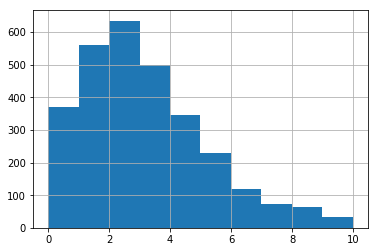

In [14]:
vec[vec<10].hist()


In [15]:
vec=df.loc[df["C15_POP15P_CS3mean_CP"]<df["C15_POP15P_CS3mean_CP"].quantile(0.1),"Count_pourmil_CP"]
vec1=df.loc[df["C15_POP15P_CS3mean_CP"]>df["C15_POP15P_CS3mean_CP"].quantile(0.9),"Count_pourmil_CP"]

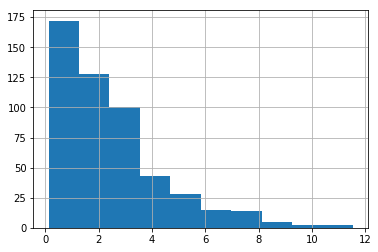

In [16]:
vec[vec<12].hist()

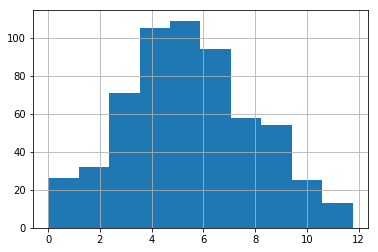

In [17]:
vec1[vec1<12].hist()

In [18]:
vec=df.loc[df["P15_POP65Pmean_CP"]<df["P15_POP65Pmean_CP"].quantile(0.3),"Count_pourmil_CP"]
vec1=df.loc[df["P15_POP65Pmean_CP"]>df["P15_POP65Pmean_CP"].quantile(0.7),"Count_pourmil_CP"]

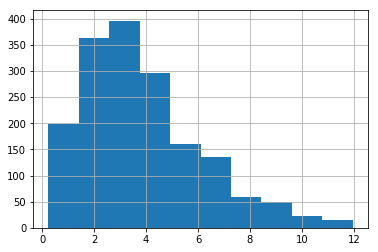

In [19]:
vec1[vec1<12].hist()

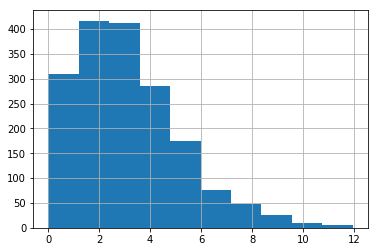

In [20]:
vec[vec<12].hist()